# About this workbook
***
This workbook utilizes a grocery store dataset collected from Kaggle. This dataset will be used to generate multiple clustering models in order to demonstrate the value of this analytics approach. The original dataset can be found through the URL below.

URL: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset

## Workbook Set Up


In [1]:
# import the required python libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
# Set seaborn styles
sns.set(font_scale=1.6)
sns.set_style(style='whitegrid',
              rc={'axes.spines.left': True
                 ,'axes.spines.bottom': True
                 ,'axes.spines.top': False
                 ,'axes.spines.bottom': True
                 ,'axes.spines.right': False
                 ,'axes.spines.left': True
                 ,'axes.facecolor': 'white'
                 ,'axes.edgecolor': 'lightgray'
                 ,'ytick.left': True
                 ,'xtick.bottom': True
                 ,'grid.linestyle': '--'
                 ,'font.family': ['Arial']})

In [3]:
# read in dataset. This is stored in my local repo but is not tracked in the remote repository.
# the "../" is to go back two folders since I store the data in the root of my local repository.
data = pd.read_csv("../../data/Groceries_dataset.csv")

## Initial Data Exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


When reading your data into python it's always good to start by using the .info() method from pandas. This allows you to see how many records are in your dataset as well as the data types in your dataframe. For example, I see that the columns are using a different case style than what I like and the date column is an object or "text" rather than an actual date. Converting this column to a date will allow more to use conventional date expressions if I need to.

In [5]:
# Update column names
data.columns = ['member_id', 'date', 'item_desc']

In [6]:
# Update date column data type
# I have to use to_datetime twice since the date is stored as dd-mm-yyyy
data['date'] = pd.to_datetime(pd.to_datetime(data["date"]).dt.strftime('%Y-%m-%d'))

In [7]:
data.head()

,member_id,date,item_desc
0,1808,2015-07-21,tropical fruit
1,2552,2015-05-01,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-01-02,whole milk


In [8]:
# Setting the random state will ensure the same 5 randomly selected rows come up again when you run this code block.
data.sample(5, random_state=9)

,member_id,date,item_desc
7925,2201,2015-05-22,bottled water
38212,3563,2014-08-14,candy
23168,3772,2015-02-18,waffles
16764,2289,2015-04-11,tropical fruit
5500,2415,2015-08-08,newspapers


Now that our data types are correct it's good to use the .head() and .sample() methods. The .head() method will show you the first five rows of data whereas the .sample() method will show you a random sample of the rows. This allows you to see what you're working with.

In [9]:
# Create a week & month variable
data['date_week'] = pd.to_datetime(data["date"]).dt.to_period('W-SUN').dt.start_time
data['date_month'] = data['date'] - pd.tseries.offsets.MonthBegin(1)

In [10]:
# Aggregate the data per member id
cluster_df = (
    data.groupby(['member_id'], as_index=False)
    .agg(
        first_purchase=('date', 'min'),
        last_purchase=('date', 'max'),
        frequency=('item_desc', 'count'),
        unique_weeks=('date_week', 'nunique'),
        unique_months=('date_month', 'nunique'),
        items=('item_desc', 'nunique')
    )
)

# Create some additional variables
cluster_df['age'] = (cluster_df['last_purchase'] - cluster_df['first_purchase']).dt.days
cluster_df['times_per_week'] = cluster_df['frequency'] / cluster_df['unique_weeks']
cluster_df['times_per_month'] = cluster_df['frequency'] / cluster_df['unique_months']
cluster_df['product_breadth'] = cluster_df['items'] / data['item_desc'].nunique()

In [11]:
cluster_df.describe().T

,count,mean,std,min,25%,50%,75%,max
member_id,"3,898.00","3,002.96","1,155.81","1,000.00","1,999.25","3,004.50","4,002.75","5,000.00"
frequency,"3,898.00",9.94,5.31,2.00,6.00,9.00,13.00,36.00
unique_weeks,"3,898.00",3.78,1.85,1.00,2.00,4.00,5.00,11.00
unique_months,"3,898.00",3.57,1.66,1.00,2.00,3.00,5.00,10.00
items,"3,898.00",8.92,4.40,1.00,6.00,8.50,12.00,26.00
age,"3,898.00",374.50,205.54,0.00,224.00,405.00,546.00,724.00
times_per_week,"3,898.00",2.63,0.70,2.00,2.00,2.50,3.00,9.00
times_per_month,"3,898.00",2.78,0.81,2.00,2.17,2.60,3.00,9.00
product_breadth,"3,898.00",0.05,0.03,0.01,0.04,0.05,0.07,0.16


Using the .describe() method will show you basic statistics about your data. For example, I'm looking for variables that have a normal(ish) distribution. Looking at the product breadth column I see that the mean and median, which suggests that the data follows a normal distribution. Plotting these variables will confirm this.

What I'm also looking for are any columns that would contain outliers. For example, we know that 50% of the members purchased from us 6 to 13 times (our IQR), but we do have a customer that has been in the store 36 times. This 36 might be an outlier and thus may impact our clustering algorithm.

## Histograms
Histograms are great for identifying what variables are highly skewed or follow a normal distribution.

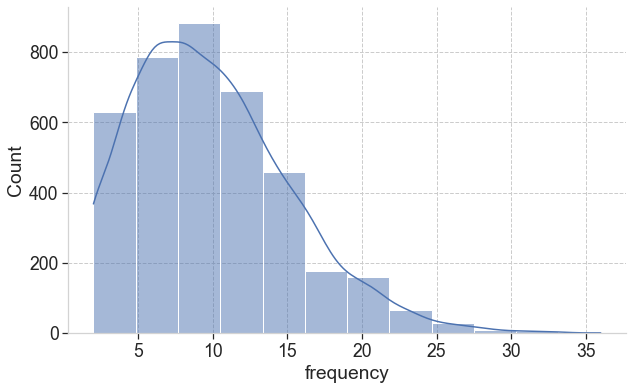

In [12]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(x='frequency', data=cluster_df, bins=12, kde=True)
plt.show()

In the graph above you can see that plotting frequency, or number of transactions, has a right skewness. These variables will impact our clustering algorithm and should have some treatment technique to make it more useful.

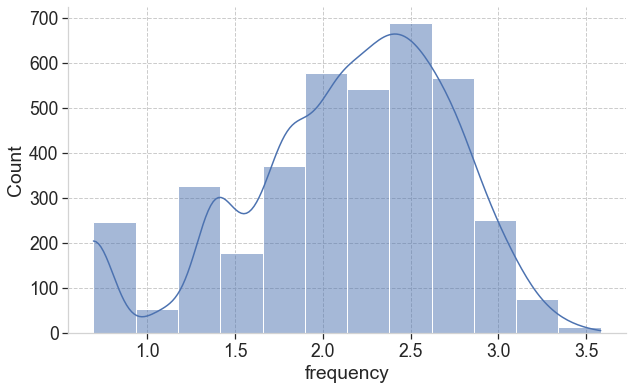

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(x=np.log(cluster_df['frequency']), data=cluster_df, bins=12, kde=True)
plt.show()

Using a log transformation on frequency does seem to help the distribution appear more normal. This will help our model.

In [14]:
cluster_df['frequency_log'] = np.log(cluster_df['frequency'])

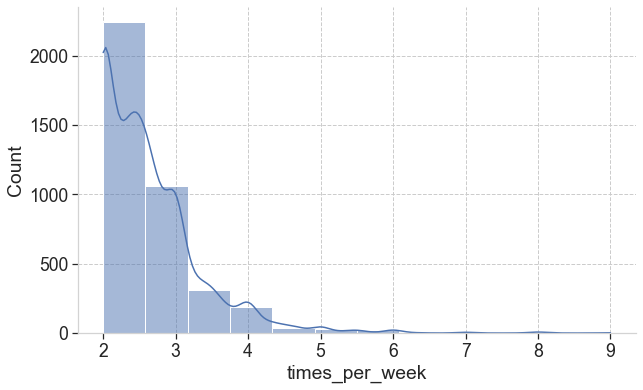

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(x='times_per_week', data=cluster_df, bins=12, kde=True)
plt.show()

You can tell above that the times per week variable is highly skewed. Instead of dropping values lets cap the column at 6.

In [16]:
cluster_df['times_per_week_adj'] = np.where(cluster_df['times_per_week'] > 6, 6, cluster_df['times_per_week'])

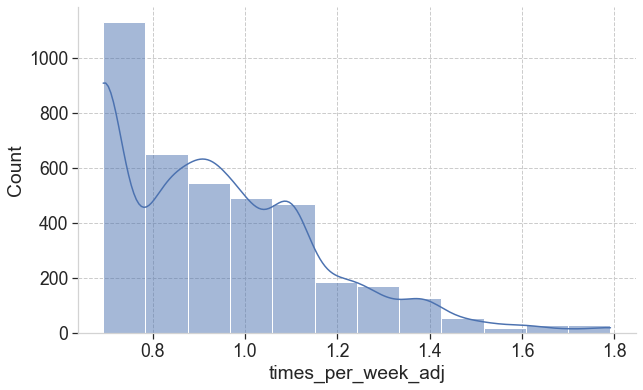

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(x=np.log(cluster_df['times_per_week_adj']), data=cluster_df, bins=12, kde=True)
plt.show()

This transformation didn't seem to work well with the data. I'd recommend just staying with the frequency column.

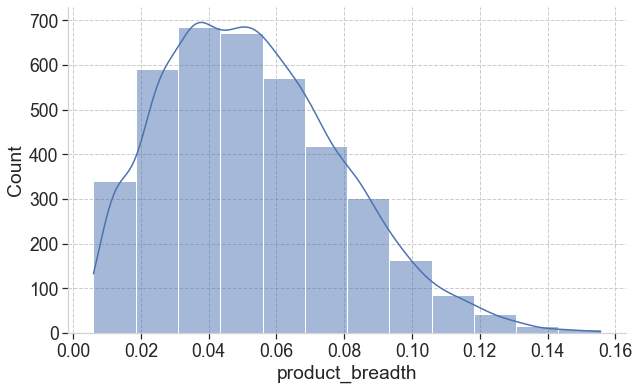

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(x='product_breadth', data=cluster_df, bins=12, kde=True)
plt.show()

The above graph looks to have a fairly good natural normal distribution. I don't think it would be beneficial to transform this column further.

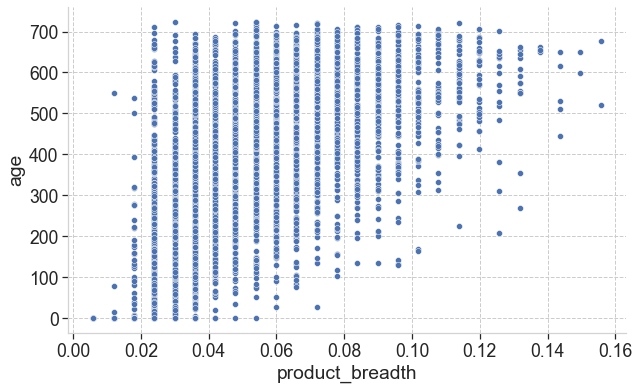

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='product_breadth', y='age', data=cluster_df)

## Clustering
### Logical Clustering
***

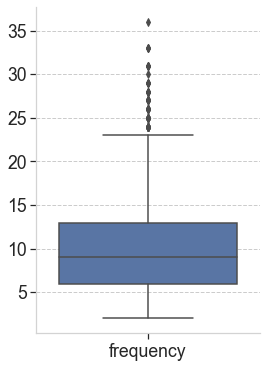

In [20]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(cluster_df[['frequency']]))
plt.xlabel("")
plt.ylabel("")
plt.show()

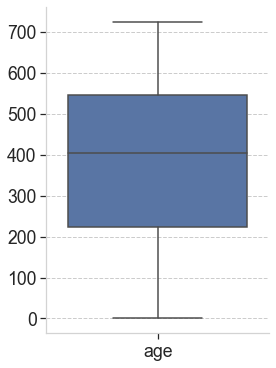

In [21]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(cluster_df[['age']]))
plt.xlabel("")
plt.ylabel("")
plt.show()

In [22]:
cluster_df[['frequency', 'age']].describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,"3,898.00",9.94,5.31,2.00,6.00,9.00,13.00,36.00
age,"3,898.00",374.50,205.54,0.00,224.00,405.00,546.00,724.00


In [23]:
def logical_cluster(frequency, age):
    if frequency < 6 and age < 224:
        return "Group 1"
    
    if frequency < 9 and age < 405:
        return "Group 2"
    
    if frequency < 13 and age < 546:
        return "Group 3"
    else:
        return "Group 4"
        
    

In [24]:
cluster_df['logical_cluster'] = cluster_df.apply(lambda x: logical_cluster(x.frequency, x.age), axis=1)

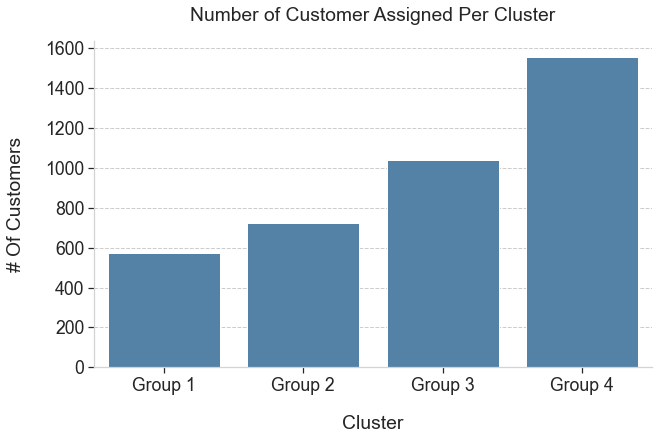

In [25]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='logical_cluster', data=cluster_df, color='steelblue', order=['Group 1', 'Group 2', 'Group 3', 'Group 4'])
plt.xlabel("Cluster", labelpad=20)
plt.ylabel("# Of Customers", labelpad=20)
plt.title("Number of Customer Assigned Per Cluster", pad=20)
plt.show()

In [26]:
from sklearn.metrics import silhouette_score

In [27]:
score = silhouette_score(cluster_df[['frequency', 'age']], cluster_df['logical_cluster'])
print(f"Logical Cluster Score: {score:0.2%}")

Logical Cluster Score: 19.52%


In [28]:
temp_df = data.copy()
temp_df = temp_df.merge(cluster_df[['member_id', 'logical_cluster']], how='left', on='member_id')
temp_df = (
    temp_df.groupby(['logical_cluster', 'item_desc'], as_index=False)
    .agg(
        frequency=('item_desc', 'count')
    )
)
temp_df['row_id'] = temp_df.groupby('logical_cluster')['frequency'].rank(method='first', ascending=False)

In [29]:
temp_df[temp_df['row_id'] <= 5].sort_values(by='logical_cluster').sort_values(by='frequency', ascending=False)

,logical_cluster,item_desc,frequency,row_id
625,Group 4,whole milk,1475,1.00
564,Group 4,other vegetables,1079,2.00
583,Group 4,rolls/buns,965,3.00
599,Group 4,soda,846,4.00
626,Group 4,yogurt,773,5.00
460,Group 3,whole milk,619,1.00
398,Group 3,other vegetables,490,2.00
418,Group 3,rolls/buns,446,3.00
434,Group 3,soda,374,4.00
461,Group 3,yogurt,325,5.00


### Algorithm Based Clustering

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [31]:
x = cluster_df[['frequency_log', 'age', 'product_breadth']]

scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)

In [32]:
sse = []
for i in range(2, 11):
    k_means = KMeans(n_clusters=i, random_state=42).fit(x_scaled)
    sse.append([i, k_means.inertia_])
    

In [33]:
sse = pd.DataFrame(sse, columns=['clusters', 'sse'])

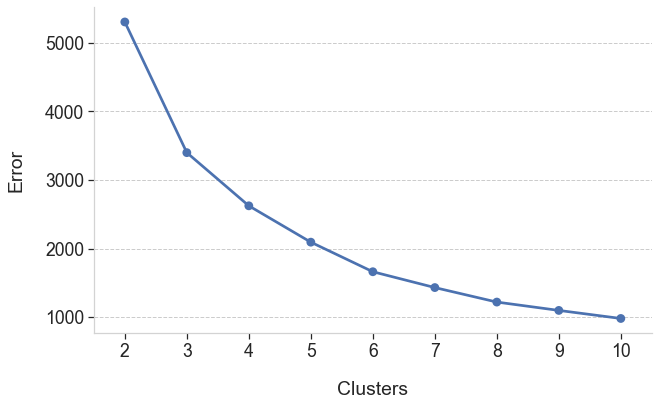

In [34]:
plt.figure(figsize=(10, 6))
ax = sns.pointplot(x='clusters', y='sse', data=sse)
plt.xlabel("Clusters", labelpad=20)
plt.ylabel("Error", labelpad=20)
plt.show()

In [35]:
model = KMeans(n_clusters=5, random_state=42).fit(x_scaled)

In [36]:
score = silhouette_score(x_scaled, model.labels_)
print(f"Logical Cluster Score: {score:0.2%}")

Logical Cluster Score: 36.06%


In [37]:
cluster_df['kmeans'] = model.labels_
cluster_df['kmeans'] = cluster_df['kmeans'] + 1

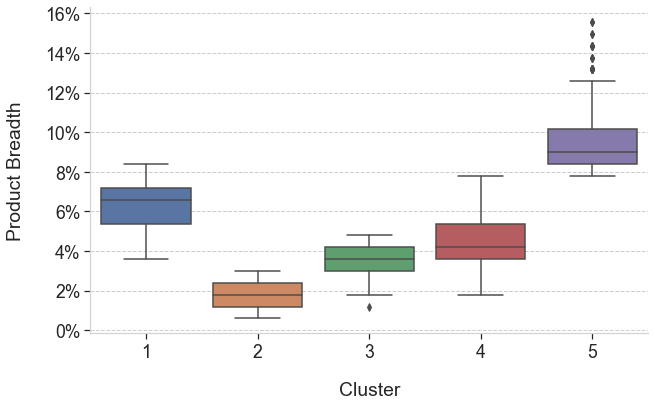

In [38]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='kmeans', y='product_breadth', data=cluster_df)
plt.xlabel("Cluster", labelpad=20)
plt.ylabel("Product Breadth", labelpad=20)
ax.set_yticklabels(["{:,.0%}".format(x) for x in ax.get_yticks()])
plt.show()